## Analysis and visualization of Lasso model results
Author: Robert Ietswaart  
Date: 20240122  
License: BSD2.  
ij: interactive job with 4 cores and 128GB RAM.
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.  
Python v3.7.4

Source: `ML_20230329_subcell_analysis.ipynb`  
For RNA flow project.
This code dev for py script for a batch run.

In [1]:
import os
import re
import copy
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import logging
import argparse
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns
from scipy.stats import ttest_1samp, ttest_rel

from sklearn.model_selection import train_test_split, KFold
from sklearn import linear_model

from __init__ import default_logger_format, default_date_format 

In [2]:
# def main():
np.random.seed(12345)

parser = argparse.ArgumentParser(
    description='Analysis and visualization of Lasso model results')

num2feat_files = {1: 'gene_structure_v2.txt gene_structure_agarwal.txt',
                  2: 'gene_sequence_v2.txt gene_sequence_agarwal.txt',
                  3: 'Codon_features.tsv.gz', 4: 'kmer_ORF_features.tsv.gz',
                  5: 'kmer_5UTR_features.tsv.gz', 6: 'kmer_3UTR_features.tsv.gz',
                  7: 'polyA_tail_length_data.txt', 8: 'RNA_modifications_v2.txt',
                  9: 'gene_location_v2.txt', 10: 'histone_modifications_v1.txt',
                  11: 'microRNA_targets_v2.txt', 12: 'RBP_targets_filter_v2.txt',
                  13: 'TF_scRNAseq_v1.csv', 14: 'TF_MSigDB_targets_v2.tsv'}

args = parser.parse_args("")#EDIT: added "" as argument to run in ipynb instead of .py script

In [3]:
path = os.path.join('/n','groups','churchman','ri23','bseq','ML20240122')
feature_path = os.path.join('/n','groups','churchman','ri23','bseq','RF20220426','features')

# Add a logger specific to the project and processing stage
logger = logging.getLogger('ML')
log_file = os.path.join(path,'LogErr', 'LASSO_20240122_subcell_analysis.log')
formatter = logging.Formatter(default_logger_format,
                              datefmt=default_date_format)
log_handler = logging.FileHandler(log_file)
log_handler.setFormatter(formatter)
logger.addHandler(log_handler)

organisms = ['m','h']
org_map = {'m': 'mouse', 'h': 'human'}
org_red_reps = {'m': ['G_R','H_S'], 'h': ['T', 'U']}

k_bound_lo = 1e-4 #unit: min^-1: 1 per 7 days
k_bound_hi = 1e4 #unit: min^-1: 1 per 6 ms

RATE_TYPE = ['half_life_','k_']

rt = RATE_TYPE[1] #ML model dependent variable: rates

Timescales = ['chr',
              'chr_release',
              'nucdeg',
              'nucexp',
              'nuc',
              'cyto',
              'poly_entry',
              'whole_cell']
Timescales = [rt + ts for ts in Timescales]

OUT_TYPES = ['.Mean', '.MAP', '.0.975.quantile', '.0.025.quantile']

B = dict()      #Bayes fits file
K = dict()      #Bayes Factor

o = 'h'
# for o in organisms:    
path_b = os.path.join('/n','groups','churchman','ri23','bseq','Bayes20240120_K562')
filename_b = 'Bayes_Rates_20240120_'+ org_map[o] + '_final.tsv'
path_k = os.path.join('/n','groups','churchman','ri23','bseq','BayesFactor20240112')
filename_k = 'Bayes_factor_20240112_' + org_map[o] + '_final.tsv'

B[o] = pd.read_csv(os.path.join(path_b, filename_b), sep='\t')
K[o] = pd.read_csv(os.path.join(path_k, filename_k), sep='\t')

### Preprocess rates: dependent variables in model
- preprocess nucexp: nucexp_from_chr or nucexp_from_nucdeg depending on nucdeg no or yes 
- clip to domain bounds
- log transform
- standardize

In [4]:
T_bf = 100

C = copy.deepcopy(B)
# for o in organisms:
C[o] = C[o].merge(K[o], on='Gene', how='outer', suffixes=('', '_bf'))
logger.info('%s all genes: %d' % (org_map[o], len(C[o])))

for ot in OUT_TYPES:
    for rr in org_red_reps[o]:
        ts = rt + 'chr_release'
        C[o][rr+'.'+ts+ot] = copy.deepcopy(C[o][rr+'.'+ts+'_from_nucdeg.MAP'].where(
                C[o]['PUND'], C[o][rr+'.'+rt+'chr'+ot]))
        ts = rt + 'nucdeg'#only for nucdeg genes according to Bayes Factor
        C[o][rr+'.'+ts+ot] = copy.deepcopy(C[o][rr+'.'+ts+'.MAP'].where(C[o]['PUND'], np.nan))
        ts = rt + 'nucexp'
        C[o][rr+'.'+ts+ot] = copy.deepcopy(C[o][rr+'.'+ts+'_from_nucdeg.MAP'].where(
            C[o]['PUND'], C[o][rr+'.'+ts+'_from_nucres'+ot])) 


        for ts in Timescales:

            ###Clip range of values beyond numerical integration domain bounds                  
            C[o][rr+'.'+ts+ot].where(((C[o][rr+'.'+ts+ot] > k_bound_lo) | (C[o][rr+'.'+ts+ot].isna())), 
                                     k_bound_lo, inplace=True) 
            C[o][rr+'.'+ts+ot].where(((C[o][rr+'.'+ts+ot] < k_bound_hi) | (C[o][rr+'.'+ts+ot].isna())), 
                                     k_bound_hi, inplace=True)  

            #standardize rates (to Z-score) to enhance learning
            rates = np.log(C[o][rr+'.'+ts+ot])
            C[o][rr+'z'+ts+ot] = (rates - rates.mean()) / rates.std()
            
Timescales.remove(rt+'nucdeg')            

INFO: [2024-01-23 09:57:01] ML - human all genes: 18165


In [5]:
subfolder = 'select_features'
L1_alpha = [0.0001, 0.00033, 0.00066, 0.001, 0.0033, 0.0066, 0.01, 0.033, 0.066, 0.1]
rand_seed = 42
shuffle = True
test_size = 0.1

RND2 = dict()
for ts in Timescales:
    logger.info('Load r2 train/cv/test and features for %s' % ts)
    filename = 'LASSO2_'+ts+'_r2_' 
    RND2[ts+'r2_train'] = pd.read_csv(os.path.join(path,subfolder,filename+'train.tsv'),sep='\t')
    RND2[ts+'r2_cv'] = pd.read_csv(os.path.join(path,subfolder,filename+'cv.tsv'),sep='\t') 
    RND2[ts+'r2_test'] = pd.read_csv(os.path.join(path,subfolder,filename+'test_seed'+str(rand_seed)+'.tsv'),sep='\t')     

    for a_ in L1_alpha:
        a_ = str(a_)
        filename = 'LASSO2_'+ts+'_alpha'+a_+'_nonzero_feats.tsv'
        RND2[ts+a_] = pd.read_csv(os.path.join(path,subfolder,filename),sep='\t')
        
        
ts = 'Agarwal whole cell half lives'
logger.info('Load r2 train/cv/test and features for %s' % ts)
filename = 'LASSO2_Agarwal_tcvtsplit_r2_'
RND2[ts+'r2_train'] = pd.read_csv(os.path.join(path,subfolder,filename+'train.tsv'),sep='\t')
RND2[ts+'r2_cv'] = pd.read_csv(os.path.join(path,subfolder,filename+'cv.tsv'),sep='\t') 
RND2[ts+'r2_test'] = pd.read_csv(os.path.join(path,subfolder,filename+'test_seed'+str(rand_seed)+'.tsv'),sep='\t')     

for a_ in L1_alpha:
    a_ = str(a_)
    filename = 'LASSO2_Agarwal_tcvtsplit_alpha'+a_+'_nonzero_feats.tsv'
    RND2[ts+a_] = pd.read_csv(os.path.join(path,subfolder,filename),sep='\t')

INFO: [2024-01-23 09:57:22] ML - Load r2 train/cv/test and features for k_chr
INFO: [2024-01-23 09:57:22] ML - Load r2 train/cv/test and features for k_chr_release
INFO: [2024-01-23 09:57:22] ML - Load r2 train/cv/test and features for k_nucexp
INFO: [2024-01-23 09:57:23] ML - Load r2 train/cv/test and features for k_nuc
INFO: [2024-01-23 09:57:23] ML - Load r2 train/cv/test and features for k_cyto
INFO: [2024-01-23 09:57:23] ML - Load r2 train/cv/test and features for k_poly_entry
INFO: [2024-01-23 09:57:23] ML - Load r2 train/cv/test and features for k_whole_cell
INFO: [2024-01-23 09:57:23] ML - Load r2 train/cv/test and features for Agarwal whole cell half lives


In [6]:
cv_folds = 10

def get_cv_alpha_opt(ts):    
    #simple max average R2CV + max on overfitting train vs CV
    max_train_cv_ratio = 1.1 #require at most 10% training overfitting compared to CV to identify robust features
    r2_opt = 0
    alpha_opt = np.nan
    for a_ in L1_alpha:
        a_ = str(a_)
        train_samples = RND2[ts+'r2_train'][a_].values
        cv_samples = RND2[ts+'r2_cv'][a_].values      
        r2_cv = np.mean(cv_samples)
        train_cv_ratio = np.mean(train_samples) / r2_cv
        logger.info('%s %s ratio %f, r2_train %f r2_cv %f' % 
                    (ts, a_, train_cv_ratio, np.mean(train_samples), r2_cv))
        if train_cv_ratio < max_train_cv_ratio:#if not in overfitting regime
            if r2_opt < r2_cv:#better than best hypothesis so far   
                r2_opt = r2_cv
                alpha_opt = a_
                r2_cv_opt = cv_samples
                logger.info('%s r2_opt %f' % (alpha_opt, r2_opt))

    return alpha_opt, r2_cv_opt


params_opt = dict()
params_opt['rate'] = []
params_opt['alpha'] = []
params_opt['type'] = []
params_opt['r2'] = []

for ts in Timescales: 
    alpha_opt, r2_cv_opt = get_cv_alpha_opt(ts)

    #add data to dataframe used for boxplot
    params_opt['rate'].extend([ts.replace(rt,'') for _ in range(cv_folds)])
    params_opt['alpha'].extend([alpha_opt for _ in range(cv_folds)])
    params_opt['type'].extend(['CV'  for _ in range(cv_folds)])
    params_opt['r2'].extend(r2_cv_opt)
    
    params_opt['rate'].append(ts.replace(rt,''))
    params_opt['alpha'].append(alpha_opt)
    params_opt['type'].append('Test')
    params_opt['r2'].extend(RND2[ts+'r2_test'][alpha_opt].values)    
       
params_opt = pd.DataFrame.from_dict(params_opt)
params_opt['rate'] = params_opt['rate'].astype('category')
Timescales_lab = [ts.replace(rt,'') for ts in Timescales]
params_opt['rate'].cat.reorder_categories(Timescales_lab, inplace=True)
params_opt['type'] = params_opt['type'].astype('category')
params_opt['type'].cat.reorder_categories(['CV','Test'], inplace=True)

logger.info(params_opt)   

filename = 'LASSOfinal_params_opt.tsv'
params_opt.to_csv(os.path.join(path,subfolder,filename), sep='\t', index=False) 
logger.info('Write final params_opt to file %s' % filename)

INFO: [2024-01-23 09:57:37] ML - k_chr 0.0001 ratio 1.160127, r2_train 0.446809 r2_cv 0.385138
INFO: [2024-01-23 09:57:37] ML - k_chr 0.00033 ratio 1.140128, r2_train 0.442935 r2_cv 0.388496
INFO: [2024-01-23 09:57:37] ML - k_chr 0.00066 ratio 1.119034, r2_train 0.434339 r2_cv 0.388138
INFO: [2024-01-23 09:57:37] ML - k_chr 0.001 ratio 1.100471, r2_train 0.424681 r2_cv 0.385909
INFO: [2024-01-23 09:57:37] ML - k_chr 0.0033 ratio 1.046323, r2_train 0.385717 r2_cv 0.368641
INFO: [2024-01-23 09:57:37] ML - 0.0033 r2_opt 0.368641
INFO: [2024-01-23 09:57:37] ML - k_chr 0.0066 ratio 1.031234, r2_train 0.360888 r2_cv 0.349957
INFO: [2024-01-23 09:57:37] ML - k_chr 0.01 ratio 1.023452, r2_train 0.341898 r2_cv 0.334064
INFO: [2024-01-23 09:57:37] ML - k_chr 0.033 ratio 1.011005, r2_train 0.255593 r2_cv 0.252811
INFO: [2024-01-23 09:57:37] ML - k_chr 0.066 ratio 1.011162, r2_train 0.177292 r2_cv 0.175335
INFO: [2024-01-23 09:57:37] ML - k_chr 0.1 ratio 1.010380, r2_train 0.112018 r2_cv 0.110867


INFO: [2024-01-23 09:57:37] ML - Write final params_opt to file LASSOfinal_params_opt.tsv


# Subcellular rate: bar plot of CV and test set performances

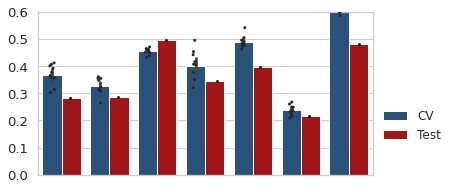

In [13]:
type_col = {'CV': '#1D5386', 'Test': '#B80000'}

fig2 = plt.figure(figsize=(6,3))
sns.set(style="whitegrid", color_codes=True,font_scale=1.2)
# ax = sns.boxplot(x='rate', y='r2', hue='type', data=params_opt,
#                  whis=[10, 90], palette=hist_type_col,flierprops=dict(alpha=0))
ax = sns.barplot(x='rate', y='r2', hue='type', data=params_opt,palette=type_col)
ax = sns.stripplot(x='rate', y='r2', hue='type', data=params_opt,
                   jitter=True,dodge=True, color='k', alpha=1,size=3,linewidth=0)      
handles, labels = ax.get_legend_handles_labels()# get legend information from the plot object
fs=12
l = plt.legend(handles[2:4], labels[2:4],loc='center left', bbox_to_anchor=(1, 0.3),fontsize=fs,frameon=False)
plt.ylim([0, 0.6])

plt.xticks(rotation = 60)
plt.xlabel('', fontsize=fs)
plt.ylabel('',fontsize=fs)#'R^2'
ax.set(xticklabels=[])#Timescales_lab)#


filename = 'LASSO2_subcell_cv_test_bar.'
plt.savefig(os.path.join(path,'figures',filename+'pdf'), bbox_inches="tight", transparent=True)
# plt.savefig(os.path.join(path,'figures',filename+'png'), bbox_inches="tight", transparent=True) 

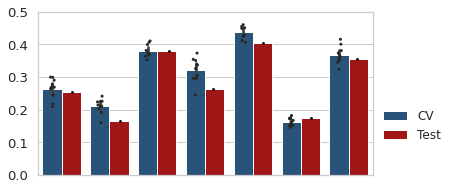

In [7]:
#2023 old rates version

##  Bar chart of performance comparison with Agarwal et al

In [14]:
agar_compare = dict()
agar_compare['rate'] = []
agar_compare['alpha'] = []
agar_compare['type'] = []
agar_compare['r2'] = []

agar_types = [Timescales[-1], 'Agarwal whole cell half lives', 'Agarwal model and half lives']
for ts in agar_types[:2]:
    alpha_opt, r2_cv_opt = get_cv_alpha_opt(ts)

    #add data to dataframe used for boxplot
    agar_compare['rate'].extend([ts for _ in range(cv_folds)])
    agar_compare['alpha'].extend([alpha_opt for _ in range(cv_folds)])
    agar_compare['type'].extend(['CV'  for _ in range(cv_folds)])
    agar_compare['r2'].extend(r2_cv_opt)

    agar_compare['rate'].append(ts)
    agar_compare['alpha'].append(alpha_opt)
    agar_compare['type'].append('Test')
    agar_compare['r2'].extend(RND2[ts+'r2_test'][alpha_opt].values) 



#add data to dataframe used for boxplot
agar_compare['rate'].append('Agarwal model and half lives')
agar_compare['alpha'].append(np.nan)
agar_compare['type'].append('CV')
agar_compare['r2'].append(0.78**2)#Pearson correlation CV r=0.78 taken from biorXiv: BC3MS+BeEM

agar_compare = pd.DataFrame.from_dict(agar_compare)
agar_compare['rate'] = agar_compare['rate'].astype('category')
agar_compare['rate'].cat.reorder_categories(agar_types, inplace=True)
agar_compare['type'] = agar_compare['type'].astype('category')
agar_compare['type'].cat.reorder_categories(['CV','Test'], inplace=True)

logger.info(agar_compare)

filename = 'LASSOagarwal_params_opt.tsv'
agar_compare.to_csv(os.path.join(path,subfolder,filename), sep='\t', index=False) 
logger.info('Write final params_opt to file %s' % filename)

INFO: [2024-01-23 10:03:09] ML - k_whole_cell 0.0001 ratio 1.158066, r2_train 0.766958 r2_cv 0.662275
INFO: [2024-01-23 10:03:09] ML - k_whole_cell 0.00033 ratio 1.144764, r2_train 0.761156 r2_cv 0.664902
INFO: [2024-01-23 10:03:09] ML - k_whole_cell 0.00066 ratio 1.131933, r2_train 0.751627 r2_cv 0.664021
INFO: [2024-01-23 10:03:09] ML - k_whole_cell 0.001 ratio 1.123985, r2_train 0.743057 r2_cv 0.661091
INFO: [2024-01-23 10:03:09] ML - k_whole_cell 0.0033 ratio 1.103779, r2_train 0.709885 r2_cv 0.643140
INFO: [2024-01-23 10:03:09] ML - k_whole_cell 0.0066 ratio 1.093777, r2_train 0.669739 r2_cv 0.612318
INFO: [2024-01-23 10:03:09] ML - 0.0066 r2_opt 0.612318
INFO: [2024-01-23 10:03:09] ML - k_whole_cell 0.01 ratio 1.082070, r2_train 0.626449 r2_cv 0.578936
INFO: [2024-01-23 10:03:09] ML - k_whole_cell 0.033 ratio 1.014783, r2_train 0.460681 r2_cv 0.453970
INFO: [2024-01-23 10:03:09] ML - k_whole_cell 0.066 ratio 1.006775, r2_train 0.379193 r2_cv 0.376641
INFO: [2024-01-23 10:03:09] M

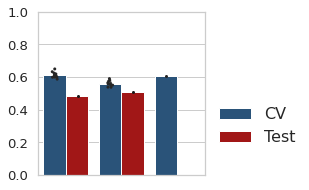

In [15]:
type_col = {'CV': '#1D5386', 'Test': '#B80000'}
    
fig2 = plt.figure(figsize=(3,3))
sns.set(style="whitegrid", color_codes=True,font_scale=1.2)
ax = sns.barplot(x='rate', y='r2', hue='type', data=agar_compare,palette=type_col)
ax = sns.stripplot(x='rate', y='r2', hue='type', data=agar_compare,
                   jitter=True,dodge=True, color='k', alpha=1,size=3,linewidth=0)      
handles, labels = ax.get_legend_handles_labels()# get legend information from the plot object
fs=16
l = plt.legend(handles[2:4], labels[2:4],loc='center left', bbox_to_anchor=(1, 0.3),fontsize=fs,frameon=False)
plt.ylim([0, 1])

plt.xticks(rotation = 75)
plt.xlabel('', fontsize=fs)
plt.ylabel('',fontsize=fs)#'R2'
ax.set(xticklabels=[])#['Our model, our rates', 'Our model, Agarwal rates', 'Agarwal model and rates'])


filename = 'LASSO2_Agarwal_comparison_bar.'
plt.savefig(os.path.join(path,'figures',filename+'pdf'), bbox_inches="tight", transparent=True)
# plt.savefig(os.path.join(path,'figures',filename+'png'), bbox_inches="tight", transparent=True) 

## Feature selection analysis

In [16]:
params_opt[['rate', 'alpha']].drop_duplicates()

,rate,alpha
0,chr,0.0033
11,chr_release,0.0033
22,nucexp,0.033
33,nuc,0.00066
44,cyto,0.00066
55,poly_entry,0.0033
66,whole_cell,0.0066


In [17]:
# feat_names = []#just for insight, not essential
rel_feat = dict()
for idx in params_opt[['rate', 'alpha']].drop_duplicates().index:
    ts = params_opt['rate'][idx]
    a_ = params_opt['alpha'][idx]
    rel_feat[ts] = RND2[rt+ts+a_]   
#     feat_names.extend(list(rel_feat[ts]['features']))
    
# feat_names.sort()
# feat_names = set(feat_names)
# logger.info(len(feat_names))
# feat_names


# Figure 7C: heatmap of feature class contributions 

- Load feature files: (takes a while)
- Load MSigDB to split according to TF vs miRNA 
- Process data and write to file

In [21]:
logger.info('Load relevant feature files %s:' % ts)

F_raw = dict()

feature_files = []
for fk in num2feat_files.keys():
    feature_files.extend(num2feat_files[fk].split())       
logger.info(feature_files)
                         
for f in feature_files:
    F_raw[f] = pd.read_csv(os.path.join(feature_path, f), sep='\t')

    logger.info('%s %d' % (f, len(F_raw[f])))
    
    if not (f in {'Codon_features.tsv.gz',#too many features to list
                 'kmer_ORF_features.tsv.gz',
                 'kmer_5UTR_features.tsv.gz',
                 'kmer_3UTR_features.tsv.gz'}):
        logger.info(F_raw[f].columns)
        logger.info(F_raw[f].head())   

INFO: [2024-01-23 10:23:33] ML - Load relevant feature files chr:
INFO: [2024-01-23 10:23:33] ML - ['gene_structure_v2.txt', 'gene_structure_agarwal.txt', 'gene_sequence_v2.txt', 'gene_sequence_agarwal.txt', 'Codon_features.tsv.gz', 'kmer_ORF_features.tsv.gz', 'kmer_5UTR_features.tsv.gz', 'kmer_3UTR_features.tsv.gz', 'polyA_tail_length_data.txt', 'RNA_modifications_v2.txt', 'gene_location_v2.txt', 'histone_modifications_v1.txt', 'microRNA_targets_v2.txt', 'RBP_targets_filter_v2.txt', 'TF_scRNAseq_v1.csv', 'TF_MSigDB_targets_v2.tsv']
INFO: [2024-01-23 10:23:33] ML - gene_structure_v2.txt 19955
INFO: [2024-01-23 10:23:33] ML - Index(['Gene', 'Symbol', 'pre_mRNA_length_max', 'n_exons_max',
       'mRNA_length_max', '3UTR_proportion_max', '5UTR_proportion_max'],
      dtype='object')
INFO: [2024-01-23 10:23:33] ML -               Gene    Symbol  pre_mRNA_length_max  n_exons_max  \
0  ENSG00000000003    TSPAN6               9995.0            8   
1  ENSG00000000005      TNMD              14

INFO: [2024-01-23 10:38:18] ML - gene_location_v2.txt 19908
INFO: [2024-01-23 10:38:18] ML - Index(['Gene', 'Symbol', 'chr_band'], dtype='object')
INFO: [2024-01-23 10:38:18] ML -               Gene    Symbol  chr_band
0  ENSG00000000003    TSPAN6    Xq22.1
1  ENSG00000000005      TNMD    Xq22.1
2  ENSG00000000419      DPM1  20q13.13
3  ENSG00000000457     SCYL3    1q24.2
4  ENSG00000000460  C1orf112    1q24.2
INFO: [2024-01-23 10:38:19] ML - histone_modifications_v1.txt 88219
INFO: [2024-01-23 10:38:19] ML - Index(['Gene', 'Symbol', 'Histone_mod'], dtype='object')
INFO: [2024-01-23 10:38:19] ML -               Gene    Symbol     Histone_mod
0  ENSG00000000419      DPM1  H3K79me2-human
1  ENSG00000000419      DPM1  H3K36me3-human
2  ENSG00000000457     SCYL3  H3K36me3-human
3  ENSG00000000460  C1orf112   H3K9me3-human
4  ENSG00000000460  C1orf112    H3K9ac-human
INFO: [2024-01-23 10:38:19] ML - microRNA_targets_v2.txt 100763
INFO: [2024-01-23 10:38:19] ML - Index(['Gene', 'Symbol', 'mi

In [22]:
#Load original MSigDB files to split TFs from miRNAs
#see MSigDB_20220426.ipynb
mpath = os.path.join('/n','groups','churchman','ri23','bseq','MSigDB')

MSDB = ['h.all','c3.mir.mirdb','c3.tft.gtrd']
cols = ['TF_MSigDB', 'Source']
cols.extend(['g'+str(i) for i in range(10000)])

M = dict()
for m in MSDB:
    filename = m + '.v7.5.1.symbols.gmt'
    if os.path.exists(os.path.join(mpath, filename)):
        M[m] = pd.read_csv(os.path.join(mpath, filename),
                           names=cols, sep='\t', header=None, dtype=str)
        M[m] = M[m]['TF_MSigDB']

# Process data and write to file

In [23]:
feat_heat = dict() #generate one tsv with all summed importances per class (row) and rates (columns)
feat_heat_n = dict() #generate one tsv with number of relevant features per class (row) and rates (columns)
feat_heat_names = dict()#generate a tsv file per each rate
feat_heat['class'] = ['Gene structure','Histone modifications','Gene location',
                      'Sequence','Codon frequencies',
                      'Poly(A) tail length', 'RNA modifications',
                      'microRNA targets','RBP targets','TF targets']
feat_heat_n['class'] = feat_heat['class']

for ts in rel_feat.keys():
    feat_heat[ts] = np.zeros(len(feat_heat['class']))
    feat_heat_n[ts] = np.zeros(len(feat_heat_n['class']))
    feat_heat_names[ts] = dict()
    for cl in feat_heat['class']:
        feat_heat_names[ts][cl] = []
    for idx in rel_feat[ts].index:
        fn = rel_feat[ts]['features'][idx]
        imp = rel_feat[ts]['importance'][idx]
        if (fn in F_raw['gene_structure_v2.txt'].columns) or \
           (fn in F_raw['gene_structure_agarwal.txt'].columns):
            cl = 'Gene structure'
        elif fn.replace('Histone_mod_','') in F_raw['histone_modifications_v1.txt']['Histone_mod'].values:
            cl = 'Histone modifications'            
        elif fn.replace('chr_band_','') in F_raw['gene_location_v2.txt']['chr_band'].values:
            cl = 'Gene location'  
        elif (fn in F_raw['gene_sequence_v2.txt'].columns) or \
            (fn in F_raw['gene_sequence_agarwal.txt'].columns) or \
            (fn in F_raw['kmer_ORF_features.tsv.gz'].columns) or \
            (fn in F_raw['kmer_5UTR_features.tsv.gz'].columns) or \
            (fn in F_raw['kmer_3UTR_features.tsv.gz'].columns):
            cl = 'Sequence'    
        elif (fn in F_raw['Codon_features.tsv.gz'].columns):
            cl = 'Codon frequencies'
        elif fn in F_raw['polyA_tail_length_data.txt'].columns:
            cl = 'Poly(A) tail length'                       
        elif fn in F_raw['RNA_modifications_v2.txt'].columns:
            cl = 'RNA modifications'  
        elif (fn.replace('TF_MSigDB_','') in M['c3.mir.mirdb'].values) or \
             (fn.replace('miRNA_family_','') in F_raw['microRNA_targets_v2.txt']['miRNA_family'].values):
            cl = 'microRNA targets'            
        elif fn.replace('RBP_','') in F_raw['RBP_targets_filter_v2.txt']['RBP'].values:
            cl = 'RBP targets' 
        elif (fn.replace('TF_MSigDB_','') in M['h.all'].values) or \
             (fn.replace('TF_MSigDB_','') in M['c3.tft.gtrd'].values) or \
             (fn.replace('TF_scRNAseq_','') in F_raw['TF_scRNAseq_v1.csv']['TF_scRNAseq'].values):
            cl = 'TF targets'
        else:
            logger.info('class not found for: %s' % fn)
        
            
        feat_heat_names[ts][cl].append(fn)
        cl_idx = feat_heat['class'].index(cl)
        feat_heat[ts][cl_idx] += imp
        feat_heat_n[ts][cl_idx] += 1
        
    feat_heat_names[ts] = pd.DataFrame.from_dict(feat_heat_names[ts],orient='index')
    filename = 'LASSOfinal_feat_class_elements_'+ts+'.tsv'
    feat_heat_names[ts].to_csv(os.path.join(path,subfolder,filename), sep='\t', index=True, header=False) 
    logger.info('Write final params_opt to file %s' % filename)

feat_heat = pd.DataFrame.from_dict(feat_heat) 
filename = 'LASSOfinal_feat_class_heatmap.tsv'
feat_heat.to_csv(os.path.join(path,subfolder,filename), sep='\t', index=False) 
logger.info('Write final summed importances for heatmap to file %s' % filename)

feat_heat_n = pd.DataFrame.from_dict(feat_heat_n) 
filename = 'LASSOfinal_feat_class_n_heatmap.tsv'
feat_heat_n.to_csv(os.path.join(path,subfolder,filename), sep='\t', index=False) 
logger.info('Write final number of rel feat per class for heatmap to file %s' % filename)

INFO: [2024-01-23 10:38:36] ML - Write final params_opt to file LASSOfinal_feat_class_elements_chr.tsv
INFO: [2024-01-23 10:38:36] ML - Write final params_opt to file LASSOfinal_feat_class_elements_chr_release.tsv
INFO: [2024-01-23 10:38:36] ML - Write final params_opt to file LASSOfinal_feat_class_elements_nucexp.tsv
INFO: [2024-01-23 10:38:37] ML - Write final params_opt to file LASSOfinal_feat_class_elements_nuc.tsv
INFO: [2024-01-23 10:38:39] ML - Write final params_opt to file LASSOfinal_feat_class_elements_cyto.tsv
INFO: [2024-01-23 10:38:39] ML - Write final params_opt to file LASSOfinal_feat_class_elements_poly_entry.tsv
INFO: [2024-01-23 10:38:41] ML - Write final params_opt to file LASSOfinal_feat_class_elements_whole_cell.tsv
INFO: [2024-01-23 10:38:41] ML - Write final summed importances for heatmap to file LASSOfinal_feat_class_heatmap.tsv
INFO: [2024-01-23 10:38:41] ML - Write final number of rel feat per class for heatmap to file LASSOfinal_feat_class_n_heatmap.tsv


In [24]:
feat_heat

,class,chr,chr_release,nucexp,nuc,cyto,poly_entry,whole_cell
0,Gene structure,0.607243,0.538219,0.510357,0.620234,0.789692,0.248691,0.561344
1,Histone modifications,0.317254,0.277552,0.164565,0.445206,0.329755,0.616344,0.215333
2,Gene location,0.000000,0.000000,0.000000,0.961216,0.419845,0.000000,0.000000
3,Sequence,0.267028,0.328873,0.281638,0.337161,0.407669,0.157044,4.587827
4,Codon frequencies,0.648187,0.652485,0.326130,0.982715,0.728604,0.616065,0.238419
5,Poly(A) tail length,0.687694,0.660017,0.491684,0.690799,0.607438,0.362903,0.344478
6,RNA modifications,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,microRNA targets,0.549452,0.642685,0.000000,2.141192,8.955134,0.232133,0.514231
8,RBP targets,1.667753,1.756706,0.441525,3.037483,3.485941,1.445448,1.482644
9,TF targets,0.477837,0.794133,0.000000,1.921626,6.903108,0.697161,0.038306


In [25]:
feat_heat_n

,class,chr,chr_release,nucexp,nuc,cyto,poly_entry,whole_cell
0,Gene structure,10.0,10.0,6.0,9.0,10.0,8.0,8.0
1,Histone modifications,5.0,6.0,2.0,8.0,12.0,9.0,3.0
2,Gene location,0.0,0.0,0.0,8.0,8.0,0.0,0.0
3,Sequence,12.0,12.0,39.0,17.0,15.0,10.0,699.0
4,Codon frequencies,40.0,41.0,17.0,53.0,48.0,38.0,19.0
5,Poly(A) tail length,9.0,9.0,3.0,9.0,10.0,10.0,9.0
6,RNA modifications,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,microRNA targets,18.0,18.0,0.0,42.0,191.0,13.0,9.0
8,RBP targets,28.0,32.0,4.0,42.0,45.0,28.0,22.0
9,TF targets,22.0,37.0,0.0,28.0,148.0,34.0,2.0


In [17]:
ts = 'chr'
feat_heat_names[ts]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
Gene structure,INTRONLEN,n_exons_max,CDSLEN,UTR5LEN,5UTR_proportion_max,UTR3LEN,mRNA_length_max,ORFEXONDENSITY,3UTR_proportion_max,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Histone modifications,Histone_mod_H3K36me3-human,Histone_mod_H3K79me2-human,Histone_mod_H4K20me1-human,Histone_mod_H2AFZ-human,Histone_mod_H3K9me1-human,Histone_mod_H3K9ac-human,Histone_mod_H3K27ac-human,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Gene location,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Sequence,gene_GC_content,TOP_motif_strong,min_5SS,ARE_motif_max_intronic,min_3SS,median_3SS,ARE_motif_n_3UTR,UTR3GC,UTR5GC,max_5SS,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Codon frequencies,Codon.CTG,Codon.TTC,Codon.TCC,Codon.CAC,Codon.GTG,Codon.ACA,Codon.CCG,Codon.AGC,Codon.AAT,Codon.TGG,Codon.CGG,Codon.GGA,Codon.CGA,Codon.TTT,Codon.CCT,Codon.TTG,Codon.ATA,Codon.GAC,Codon.AAC,Codon.TTA,Codon.GTT,Codon.GCC,Codon.ACC,Codon.GGG,Codon.CAA,Codon.CGT,Codon.CAT,Codon.GTC,Codon.TAT,Codon.CCA,Codon.TCG,Codon.CTA,Codon.TAC,Codon.GTA,Codon.TGC,Codon.TGT,Codon.AAG,Codon.ATG,Codon.GAT
Poly(A) tail length,tail_length_Q75_chromatin,tail_length_median_chromatin,tail_length_Q25_chromatin,tail_length_Q25_cytoplasm,tail_length_Q75_total,tail_length_Q75_polysome,tail_length_median_total,tail_length_Q75_cytoplasm,tail_length_Q25_polysome,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
RNA modifications,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
microRNA targets,TF_MSigDB_MIR106B_5P,TF_MSigDB_MIR19B_3P,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
RBP targets,RBP_SND1,RBP_DDX24,RBP_FAM120A,RBP_SRSF1,RBP_ZC3H11A,RBP_HNRNPK,RBP_BUD13,RBP_IGF2BP1,RBP_UCHL5,RBP_EFTUD2,RBP_MTPAP,RBP_RBFOX2,RBP_AQR,RBP_NIPBL,RBP_NOLC1,RBP_PCBP1,RBP_GTF2F1,RBP_GPKOW,RBP_PUM2,RBP_TRA2A,RBP_AKAP8L,RBP_SAFB2,RBP_QKI,RBP_YBX3,RBP_LIN28B,RBP_DDX55,RBP_KHDRBS1,RBP_XRCC6,RBP_PRPF8,None,None,None,None,None,None,None,None,None,None
TF targets,TF_MSigDB_RAG1_TARGET_GENES,TF_MSigDB_ELF2_TARGET_GENES,TF_MSigDB_NFKBIA_TARGET_GENES,TF_MSigDB_SETX_TARGET_GENES,TF_MSigDB_ZNF843_TARGET_GENES,TF_MSigDB_AHRR_TARGET_GENES,TF_MSigDB_CEBPZ_TARGET_GENES,TF_MSigDB_HOXB4_TARGET_GENES,TF_MSigDB_ZNF282_TARGET_GENES,TF_MSigDB_NFE2L1_TARGET_GENES,TF_MSigDB_ZNF581_TARGET_GENES,TF_scRNAseq_ZBTB11,TF_MSigDB_ID2_TARGET_GENES,TF_MSigDB_SETD1A_TARGET_GENES,TF_MSigDB_NFRKB_TARGET_GENES,TF_MSigDB_KDM5D_TARGET_GENES,TF_MSigDB_DBP_TARGET_GENES,TF_MSigDB_ZNF30_TARGET_GENES,TF_MSigDB_CC2D1A_TARGET_GENES,TF_MSigDB_ADA2_TARGET_GENES,TF_MSigDB_DIDO1_TARGET_GENES,TF_MSigDB_MAFG_TARGET_GENES,TF_scRNAseq_ZNF117,TF_MSigDB_ZSCAN29_TARGET_GENES,TF_MSigDB_TFEB_TARGET_GENES,None,None,None,None,None,None,None,None,None,None,None,None,None,None


# Data for Fig 7D, S10C, Table S8: add feature class to relevant features

Run after the above as stand alone

In [26]:
logger.info('Read df with relevant features')
rel_feat = dict()
for idx in params_opt[['rate', 'alpha']].drop_duplicates().index:
    ts = params_opt['rate'][idx]
    a_ = params_opt['alpha'][idx]
    rel_feat[ts] = RND2[rt+ts+a_]   

INFO: [2024-01-23 10:38:41] ML - Read df with relevant features


In [27]:
logger.info('Load files with feature name to class map (generated above)')
feat2cl = dict()
for ts in rel_feat.keys():
    filename = 'LASSOfinal_feat_class_elements_'+ts+'.tsv'
    feat2cl[ts] = pd.read_csv(os.path.join(path,subfolder,filename), 
                                      index_col=0,header=None,sep='\t') 
    feat2cl[ts] = feat2cl[ts].T

INFO: [2024-01-23 10:38:41] ML - Load files with feature name to class map (generated above)


In [28]:
feat2cl[ts].head()

,Gene structure,Histone modifications,Gene location,Sequence,Codon frequencies,Poly(A) tail length,RNA modifications,microRNA targets,RBP targets,TF targets
1,ORFEXONDENSITY,Histone_mod_H3K36me3-human,NaN,ORF.GAATT,Codon.CAC,tail_length_Q25_chromatin,NaN,miRNA_family_AAAGUGC,RBP_YBX3,TF_scRNAseq_ZBTB43
2,INTRONLEN,Histone_mod_H3K79me2-human,NaN,ORF.CACTTCG,Codon.AGG,tail_length_median_cytoplasm,NaN,miRNA_family_GUGCAAA,RBP_PABPC4,TF_MSigDB_AHRR_TARGET_GENES
3,n_exons_max,Histone_mod_H4K20me1-human,NaN,ORF.GAAATTA,Codon.TGT,tail_length_Q75_chromatin,NaN,TF_MSigDB_MIR20A_5P,RBP_RBM15,NaN
4,3UTR_proportion_max,NaN,NaN,ORF.GCGTTGC,Codon.AGT,tail_length_median_polysome,NaN,miRNA_family_AUUGCAC,RBP_DDX3X,NaN
5,mRNA_length_max,NaN,NaN,ORF.AGCAGGC,Codon.TCC,tail_length_Q75_total,NaN,TF_MSigDB_MIR19B_3P,RBP_RPS3,NaN


In [29]:
for ts in rel_feat.keys():
    feature_class = []
    for ft in rel_feat[ts]['features']:
        for cl in feat2cl[ts].columns:
            if ft in feat2cl[ts][cl].values:
                feature_class.append(cl)
                break
    rel_feat[ts]['feature_class'] =  feature_class
    filename = 'LASSOfinal_'+ts+'_a_opt_nonzero_feats_w_class.tsv'
    rel_feat[ts].to_csv(os.path.join(path,'select_features',filename), 
                                                            sep='\t', index=False) 
    logger.info('Re-write nonzero features to file, now with classes %s' % filename)    

INFO: [2024-01-23 10:38:41] ML - Re-write nonzero features to file, now with classes LASSOfinal_chr_a_opt_nonzero_feats_w_class.tsv
INFO: [2024-01-23 10:38:41] ML - Re-write nonzero features to file, now with classes LASSOfinal_chr_release_a_opt_nonzero_feats_w_class.tsv
INFO: [2024-01-23 10:38:42] ML - Re-write nonzero features to file, now with classes LASSOfinal_nucexp_a_opt_nonzero_feats_w_class.tsv
INFO: [2024-01-23 10:38:42] ML - Re-write nonzero features to file, now with classes LASSOfinal_nuc_a_opt_nonzero_feats_w_class.tsv
INFO: [2024-01-23 10:38:42] ML - Re-write nonzero features to file, now with classes LASSOfinal_cyto_a_opt_nonzero_feats_w_class.tsv
INFO: [2024-01-23 10:38:42] ML - Re-write nonzero features to file, now with classes LASSOfinal_poly_entry_a_opt_nonzero_feats_w_class.tsv
INFO: [2024-01-23 10:38:42] ML - Re-write nonzero features to file, now with classes LASSOfinal_whole_cell_a_opt_nonzero_feats_w_class.tsv


In [30]:
rel_feat[ts].head()

,features,coef,importance,feature_class
0,ORFEXONDENSITY,-0.249384,0.249384,Gene structure
1,RBP_YBX3,-0.227033,0.227033,RBP targets
2,RBP_PABPC4,-0.185724,0.185724,RBP targets
3,RBP_RBM15,0.150987,0.150987,RBP targets
4,RBP_DDX3X,-0.142792,0.142792,RBP targets
